# Machine Learning - Based Precipitation Forecast Correction over East Africa

This notebook demonstrates an attempt to correct the precipitation simulations made using the Weather Research and Forecasting (WRF) model over East Africa. Three machine learning (ML) models were used to perform the regression tasks. These were the Random Forest (RF), k-Nearest Neighbors (KNN) and Support Vector Regression (SVR). The regression was made against ground station observed precipitation records that were downloaded from OGIMET (https://www.ogimet.com/home.phtml.en).

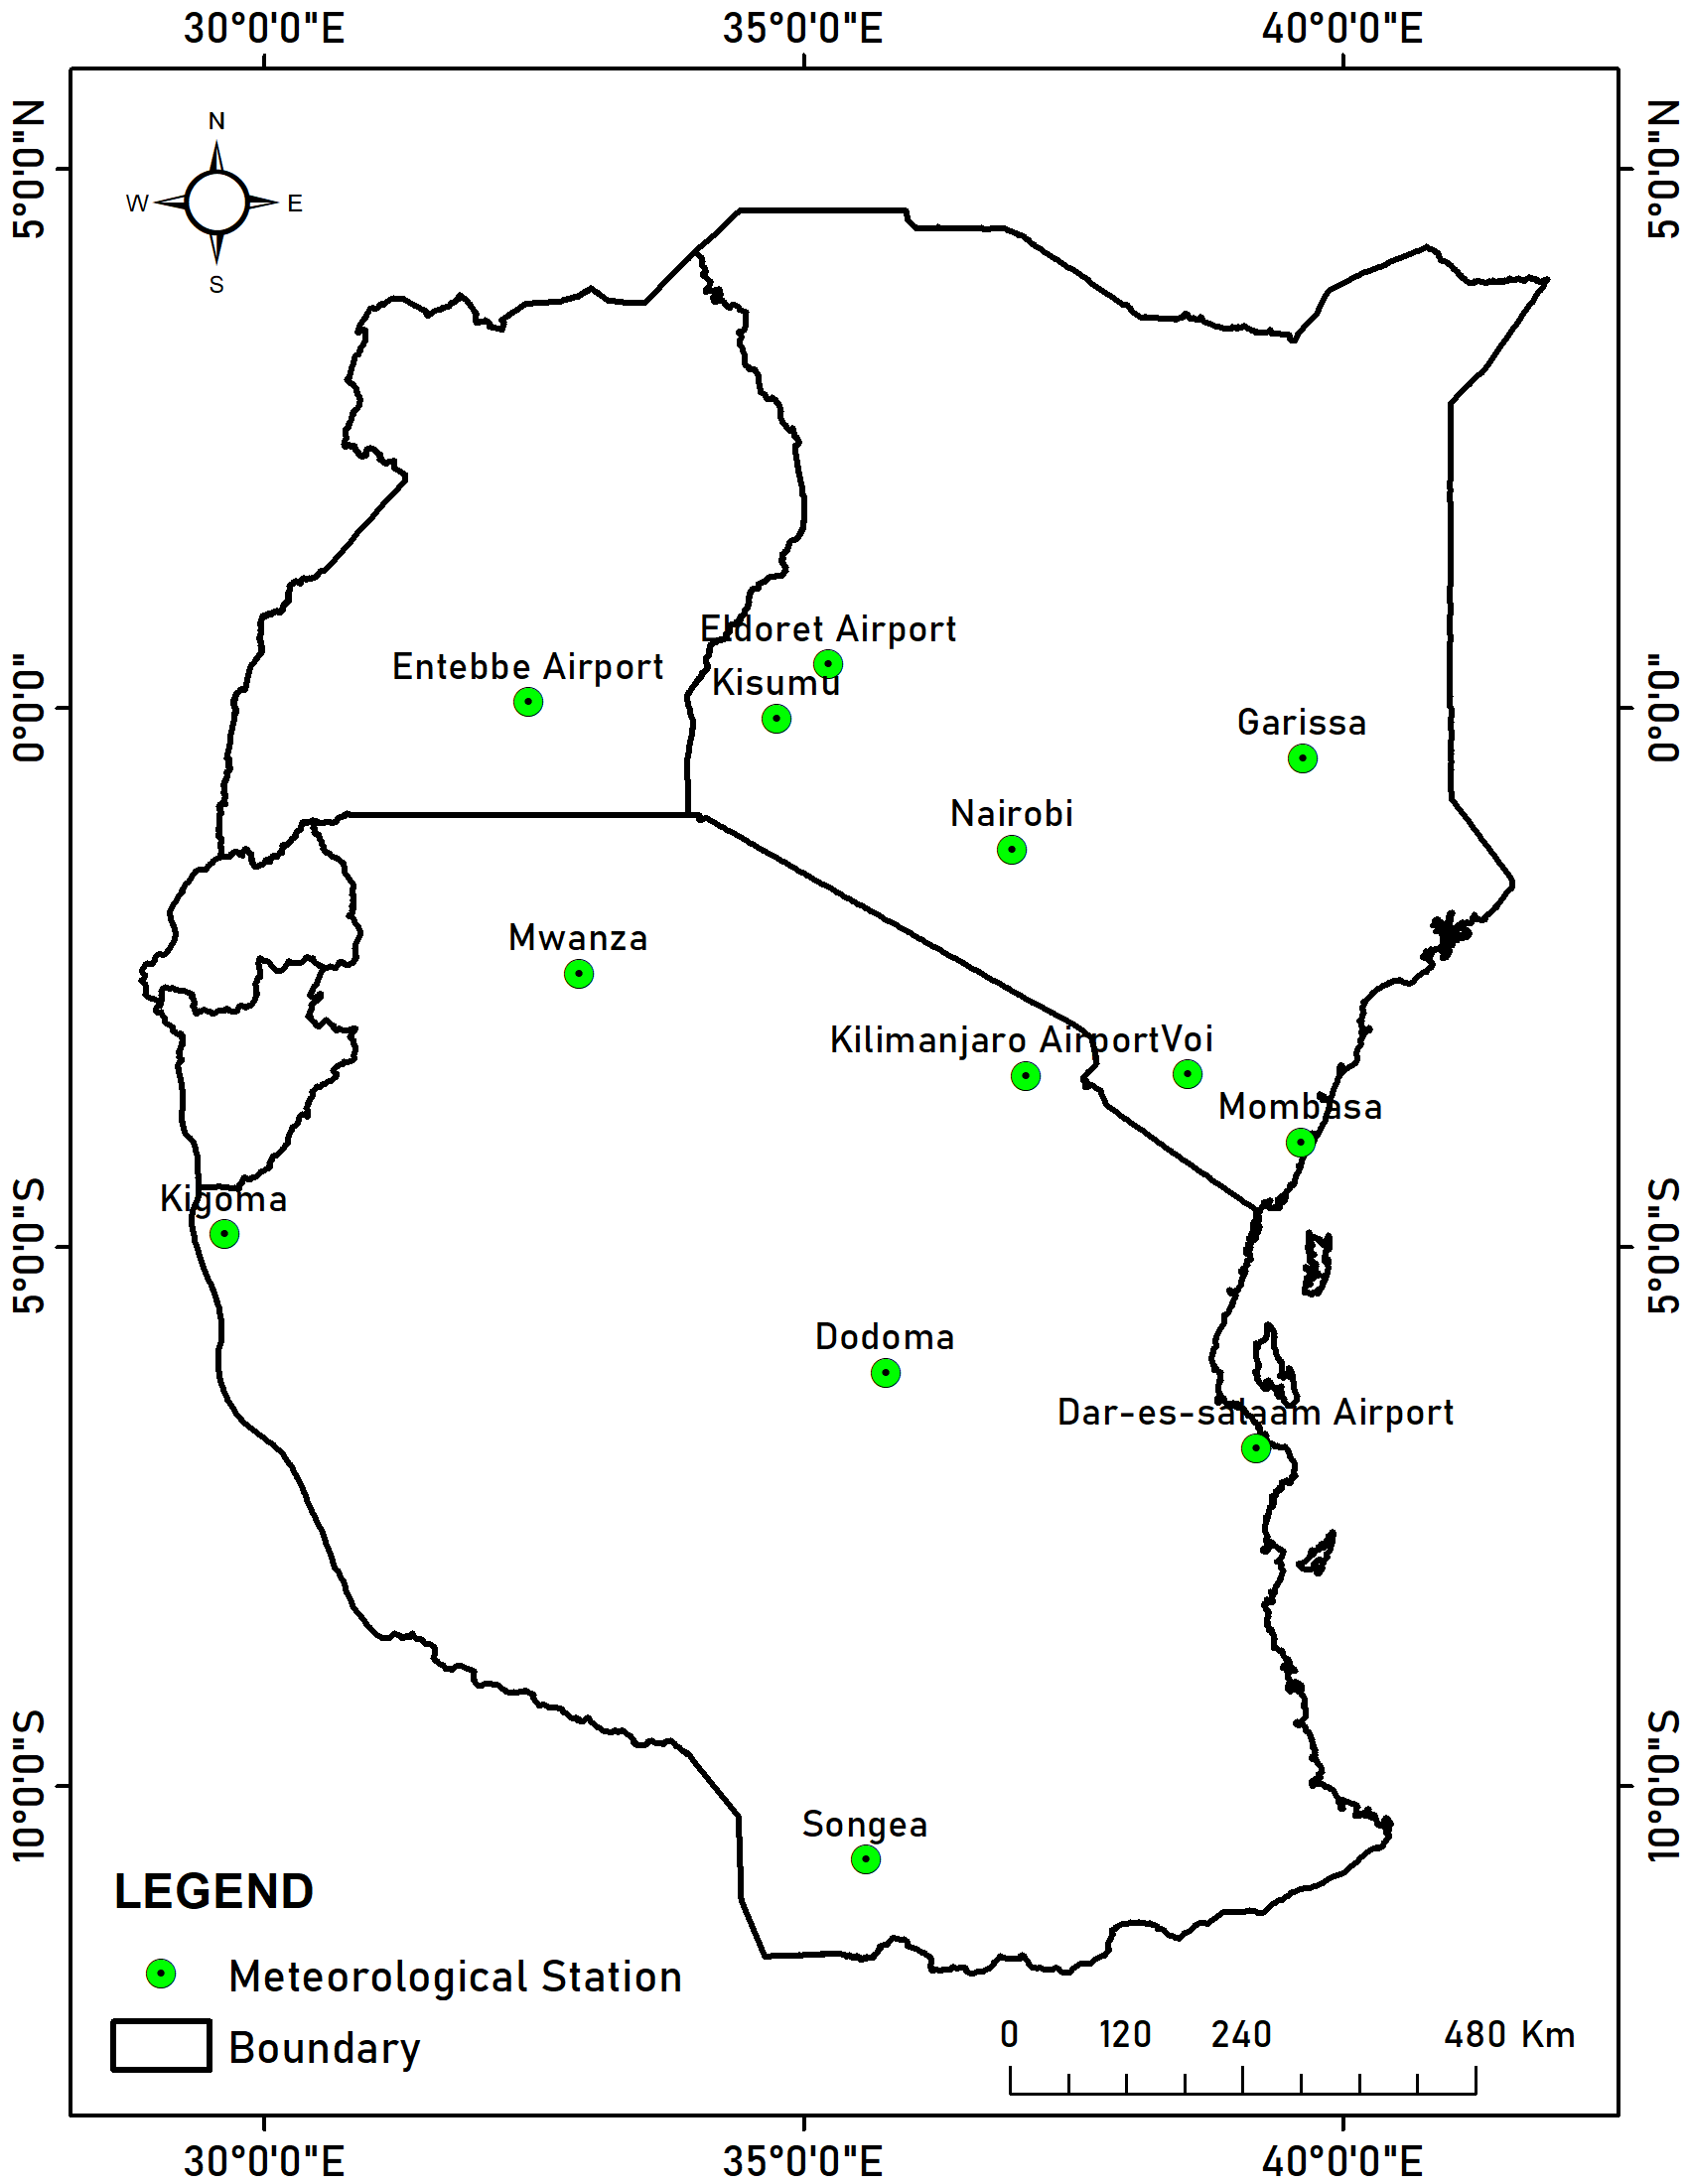

In [1]:
# Import traditional libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set the running configuration for matplotlib
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14

# Import machine learning libraries
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Import datasets
df_dar = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\dar_es_salaam.csv')
df_dod = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\dodoma.csv')
df_eld = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\eldoret.csv')
df_ebb = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\entebbe.csv')
df_gar = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\garissa.csv')
df_kig = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\kigoma.csv')
df_kil = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\kilimanjaro_ap.csv')
df_kis = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\kisumu.csv')
df_mom = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\mombasa.csv')
df_mwa = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\mwanza.csv')
df_nai = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\nairobi.csv')
df_sog = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\songea.csv')
df_voi = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\data\voi.csv')


print(df_dar.head(2))
print('==='*17)
print(df_ebb.head(2))
print('==='*17)
print(df_voi.head(2))

          day  obs_rain  wrf_rain
0  2010-06-01       NaN      0.17
1  2010-06-02       NaN      0.00
          day  obs_rain  wrf_rain
0  2010-06-01       0.0      0.00
1  2010-06-02       NaN      0.07
          day  obs_rain  wrf_rain
0  2010-06-01       0.0      0.00
1  2010-06-02       0.0      0.01


## Data Preparation

In [3]:
# Check data information and completness.
# Only 2 datasets have been sampled
df_dar.info()
print("==="*17)
df_kil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2209 entries, 0 to 2208
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       2209 non-null   object 
 1   obs_rain  1750 non-null   float64
 2   wrf_rain  2209 non-null   float64
dtypes: float64(2), object(1)
memory usage: 51.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       2250 non-null   object 
 1   obs_rain  1951 non-null   float64
 2   wrf_rain  2250 non-null   float64
dtypes: float64(2), object(1)
memory usage: 52.9+ KB


In [4]:
# Notice that data files each have 4 columns. All columns have the same number of non-empty rows 
# except for the 'obs_rain' column. This indicates that it has some missing data. 
# We shall now calculate the % of missing data for only 2 of the datasets. This has been done to keep the notebook short, however,
# missing data were found in all the other data files as well.

def percent_missing(df):
    per_null = (df.isnull().sum()/len(df))*100
    return per_null

print('Dar_es_salaam')
print(percent_missing(df_dar))
print('==='*17)
print('Kilimajaro')
print(percent_missing(df_kil))
print('==='*17)

Dar_es_salaam
day          0.000000
obs_rain    20.778633
wrf_rain     0.000000
dtype: float64
Kilimajaro
day          0.000000
obs_rain    13.288889
wrf_rain     0.000000
dtype: float64


In [5]:
# Ignore the rows in which the 'obs_rain' column has null values

df_dar = df_dar[df_dar['obs_rain'].notna()]
df_dod = df_dod[df_dod['obs_rain'].notna()]
df_eld = df_eld[df_eld['obs_rain'].notna()]
df_ebb = df_ebb[df_ebb['obs_rain'].notna()]
df_gar = df_gar[df_gar['obs_rain'].notna()]
df_kig = df_kig[df_kig['obs_rain'].notna()]
df_kil = df_kil[df_kil['obs_rain'].notna()]
df_kis = df_kis[df_kis['obs_rain'].notna()]
df_mom = df_mom[df_mom['obs_rain'].notna()]
df_mwa = df_mwa[df_mwa['obs_rain'].notna()]
df_nai = df_nai[df_nai['obs_rain'].notna()]
df_sog = df_sog[df_sog['obs_rain'].notna()]
df_voi = df_voi[df_voi['obs_rain'].notna()]

df_dar.info()
print("==="*17)
df_kil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1750 entries, 2 to 2208
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       1750 non-null   object 
 1   obs_rain  1750 non-null   float64
 2   wrf_rain  1750 non-null   float64
dtypes: float64(2), object(1)
memory usage: 54.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 1 to 2249
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   day       1951 non-null   object 
 1   obs_rain  1951 non-null   float64
 2   wrf_rain  1951 non-null   float64
dtypes: float64(2), object(1)
memory usage: 61.0+ KB


## Data Preprocessing

In [6]:
# Manually select training and testing data so as to keep track of time selection
# Data from June 2010 to May 2015 will be used for training while data from June 2015 to May 2016 will be used for testing

train_dar = df_dar[pd.to_datetime(df_dar['day']) <= '2015-05-31']
test_dar = df_dar[pd.to_datetime(df_dar['day']) > '2015-05-31']

train_dod = df_dod[pd.to_datetime(df_dod['day']) <= '2015-05-31']
test_dod = df_dod[pd.to_datetime(df_dod['day']) > '2015-05-31']

train_eld = df_eld[pd.to_datetime(df_eld['day']) <= '2015-05-31']
test_eld = df_eld[pd.to_datetime(df_eld['day']) > '2015-05-31']

train_ebb = df_ebb[pd.to_datetime(df_ebb['day']) <= '2015-05-31']
test_ebb = df_ebb[pd.to_datetime(df_ebb['day']) > '2015-05-31']

train_gar = df_gar[pd.to_datetime(df_gar['day']) <= '2015-05-31']
test_gar = df_gar[pd.to_datetime(df_gar['day']) > '2015-05-31']

train_kig = df_kig[pd.to_datetime(df_kig['day']) <= '2015-05-31']
test_kig = df_kig[pd.to_datetime(df_kig['day']) > '2015-05-31']

train_kil = df_kil[pd.to_datetime(df_kil['day']) <= '2015-05-31']
test_kil = df_kil[pd.to_datetime(df_kil['day']) > '2015-05-31']

train_kis = df_kis[pd.to_datetime(df_kis['day']) <= '2015-05-31']
test_kis = df_kis[pd.to_datetime(df_kis['day']) > '2015-05-31']

train_mom = df_mom[pd.to_datetime(df_mom['day']) <= '2015-05-31']
test_mom = df_mom[pd.to_datetime(df_mom['day']) > '2015-05-31']

train_mwa = df_mwa[pd.to_datetime(df_mwa['day']) <= '2015-05-31']
test_mwa = df_mwa[pd.to_datetime(df_mwa['day']) > '2015-05-31']

train_nai = df_nai[pd.to_datetime(df_nai['day']) <= '2015-05-31']
test_nai = df_nai[pd.to_datetime(df_nai['day']) > '2015-05-31']

train_sog = df_sog[pd.to_datetime(df_sog['day']) <= '2015-05-31']
test_sog = df_sog[pd.to_datetime(df_sog['day']) > '2015-05-31']

train_voi = df_voi[pd.to_datetime(df_voi['day']) <= '2015-05-31']
test_voi = df_voi[pd.to_datetime(df_voi['day']) > '2015-05-31']


# Check one of the datasets. We shall use Dar_es_salaam
print(train_dar)
print("===="*15)
print(test_dar)

             day  obs_rain  wrf_rain
2     2010-06-03       0.0      0.00
3     2010-06-04       0.0      0.00
4     2010-06-05       0.0      0.00
5     2010-06-06       0.0      0.00
7     2010-06-08       0.0      3.93
...          ...       ...       ...
1830  2015-05-25       1.7      2.58
1832  2015-05-27       0.0      7.28
1833  2015-05-28       0.0      5.58
1835  2015-05-30       5.2     14.47
1836  2015-05-31       0.0     16.95

[1450 rows x 3 columns]
             day  obs_rain  wrf_rain
1837  2015-06-01       8.4      1.36
1838  2015-06-02       2.7      0.01
1839  2015-06-03       0.0      0.36
1840  2015-06-04       0.0      0.00
1841  2015-06-05       0.0      0.00
...          ...       ...       ...
2203  2016-05-25       0.0      0.55
2204  2016-05-26       0.0      0.16
2206  2016-05-28       0.0      0.03
2207  2016-05-29       0.0      0.26
2208  2016-05-30       0.0      0.54

[300 rows x 3 columns]


In [7]:
# Select the data variables 

X_train_dar = train_dar['wrf_rain']
X_test_dar = test_dar['wrf_rain']
y_train_dar = train_dar['obs_rain']
y_test_dar = test_dar['obs_rain']

X_train_dod = train_dod['wrf_rain']
X_test_dod = test_dod['wrf_rain']
y_train_dod = train_dod['obs_rain']
y_test_dod = test_dod['obs_rain']

X_train_eld = train_eld['wrf_rain']
X_test_eld = test_eld['wrf_rain']
y_train_eld = train_eld['obs_rain']
y_test_eld = test_eld['obs_rain']

X_train_ebb = train_ebb['wrf_rain']
X_test_ebb = test_ebb['wrf_rain']
y_train_ebb = train_ebb['obs_rain']
y_test_ebb = test_ebb['obs_rain']

X_train_gar = train_gar['wrf_rain']
X_test_gar = test_gar['wrf_rain']
y_train_gar = train_gar['obs_rain']
y_test_gar = test_gar['obs_rain']

X_train_kig = train_kig['wrf_rain']
X_test_kig = test_kig['wrf_rain']
y_train_kig = train_kig['obs_rain']
y_test_kig = test_kig['obs_rain']

X_train_kil = train_kil['wrf_rain']
X_test_kil = test_kil['wrf_rain']
y_train_kil = train_kil['obs_rain']
y_test_kil = test_kil['obs_rain']

X_train_kis = train_kis['wrf_rain']
X_test_kis = test_kis['wrf_rain']
y_train_kis = train_kis['obs_rain']
y_test_kis = test_kis['obs_rain']

X_train_mom = train_mom['wrf_rain']
X_test_mom = test_mom['wrf_rain']
y_train_mom = train_mom['obs_rain']
y_test_mom = test_mom['obs_rain']

X_train_mwa = train_mwa['wrf_rain']
X_test_mwa = test_mwa['wrf_rain']
y_train_mwa = train_mwa['obs_rain']
y_test_mwa = test_mwa['obs_rain']

X_train_nai = train_nai['wrf_rain']
X_test_nai = test_nai['wrf_rain']
y_train_nai = train_nai['obs_rain']
y_test_nai = test_nai['obs_rain']

X_train_sog = train_sog['wrf_rain']
X_test_sog = test_sog['wrf_rain']
y_train_sog = train_sog['obs_rain']
y_test_sog = test_sog['obs_rain']

X_train_voi = train_voi['wrf_rain']
X_test_voi = test_voi['wrf_rain']
y_train_voi = train_voi['obs_rain']
y_test_voi = test_voi['obs_rain']

In [8]:
# Scaling the data

scaler = preprocessing.MinMaxScaler()

x_train_dar = scaler.fit_transform(np.asarray(X_train_dar).reshape(-1, 1), y_train_dar) # A 1-dimensional array will need reshaping
x_test_dar = scaler.fit_transform(np.asarray(X_test_dar).reshape(-1, 1), y_test_dar)

x_train_dod = scaler.fit_transform(np.asarray(X_train_dod).reshape(-1, 1), y_train_dod)
x_test_dod = scaler.fit_transform(np.asarray(X_test_dod).reshape(-1, 1), y_test_dod)

x_train_eld = scaler.fit_transform(np.asarray(X_train_eld).reshape(-1, 1), y_train_eld)
x_test_eld = scaler.fit_transform(np.asarray(X_test_eld).reshape(-1, 1), y_test_eld)

x_train_ebb = scaler.fit_transform(np.asarray(X_train_ebb).reshape(-1, 1), y_train_ebb)
x_test_ebb = scaler.fit_transform(np.asarray(X_test_ebb).reshape(-1, 1), y_test_ebb)

x_train_gar = scaler.fit_transform(np.asarray(X_train_gar).reshape(-1, 1), y_train_gar)
x_test_gar = scaler.fit_transform(np.asarray(X_test_gar).reshape(-1, 1), y_test_gar)

x_train_kig = scaler.fit_transform(np.asarray(X_train_kig).reshape(-1, 1), y_train_kig)
x_test_kig = scaler.fit_transform(np.asarray(X_test_kig).reshape(-1, 1), y_test_kig)

x_train_kil = scaler.fit_transform(np.asarray(X_train_kil).reshape(-1, 1), y_train_kil)
x_test_kil = scaler.fit_transform(np.asarray(X_test_kil).reshape(-1, 1), y_test_kil)

x_train_kis = scaler.fit_transform(np.asarray(X_train_kis).reshape(-1, 1), y_train_kis)
x_test_kis = scaler.fit_transform(np.asarray(X_test_kis).reshape(-1, 1), y_test_kis)

x_train_mom = scaler.fit_transform(np.asarray(X_train_mom).reshape(-1, 1), y_train_mom)
x_test_mom = scaler.fit_transform(np.asarray(X_test_mom).reshape(-1, 1), y_test_mom)

x_train_mwa = scaler.fit_transform(np.asarray(X_train_mwa).reshape(-1, 1), y_train_mwa)
x_test_mwa = scaler.fit_transform(np.asarray(X_test_mwa).reshape(-1, 1), y_test_mwa)

x_train_nai = scaler.fit_transform(np.asarray(X_train_nai).reshape(-1, 1), y_train_nai)
x_test_nai = scaler.fit_transform(np.asarray(X_test_nai).reshape(-1, 1), y_test_nai)

x_train_sog = scaler.fit_transform(np.asarray(X_train_sog).reshape(-1, 1), y_train_sog)
x_test_sog = scaler.fit_transform(np.asarray(X_test_sog).reshape(-1, 1), y_test_sog)

x_train_voi = scaler.fit_transform(np.asarray(X_train_voi).reshape(-1, 1), y_train_voi)
x_test_voi = scaler.fit_transform(np.asarray(X_test_voi).reshape(-1, 1), y_test_voi)

## Apply Machine Learning Correction

In [9]:
# We shall apply onl 3 kinds of ML algorithms
# Random Forest, K-Nearest Neighbors, and Support Vector Regression
rf = RandomForestRegressor()
knn = KNeighborsRegressor(n_neighbors=20)
svr = LinearSVR()

# Create the ML correction function which returns the bias-corrected precipitation forecast
def ML_correct(x_train, y_train, x_test, y_test):
    rf_reg = rf.fit(x_train, y_train)
    knn_reg = knn.fit(x_train, y_train)
    svr_reg = svr.fit(x_train, y_train)
    rf_pred = rf_reg.predict(x_test)
    knn_pred = knn_reg.predict(x_test)
    svr_pred = svr_reg.predict(x_test)
    return rf_pred, knn_pred, svr_pred

In [10]:
# Perform correction
arr_dar = ML_correct(x_train_dar, y_train_dar, x_test_dar, y_test_dar)
arr_dod = ML_correct(x_train_dod, y_train_dod, x_test_dod, y_test_dod)
arr_eld = ML_correct(x_train_eld, y_train_eld, x_test_eld, y_test_eld)
arr_ebb = ML_correct(x_train_ebb, y_train_ebb, x_test_ebb, y_test_ebb)
arr_gar = ML_correct(x_train_gar, y_train_gar, x_test_gar, y_test_gar)
arr_kig = ML_correct(x_train_kig, y_train_kig, x_test_kig, y_test_kig)
arr_kil = ML_correct(x_train_kil, y_train_kil, x_test_kil, y_test_kil)
arr_kis = ML_correct(x_train_kis, y_train_kis, x_test_kis, y_test_kis)
arr_mom = ML_correct(x_train_mom, y_train_mom, x_test_mom, y_test_mom)
arr_mwa = ML_correct(x_train_mwa, y_train_mwa, x_test_mwa, y_test_mwa)
arr_nai = ML_correct(x_train_nai, y_train_nai, x_test_nai, y_test_nai)
arr_sog = ML_correct(x_train_sog, y_train_sog, x_test_sog, y_test_sog)
arr_voi = ML_correct(x_train_voi, y_train_voi, x_test_voi, y_test_voi)

### Plot the timeseries

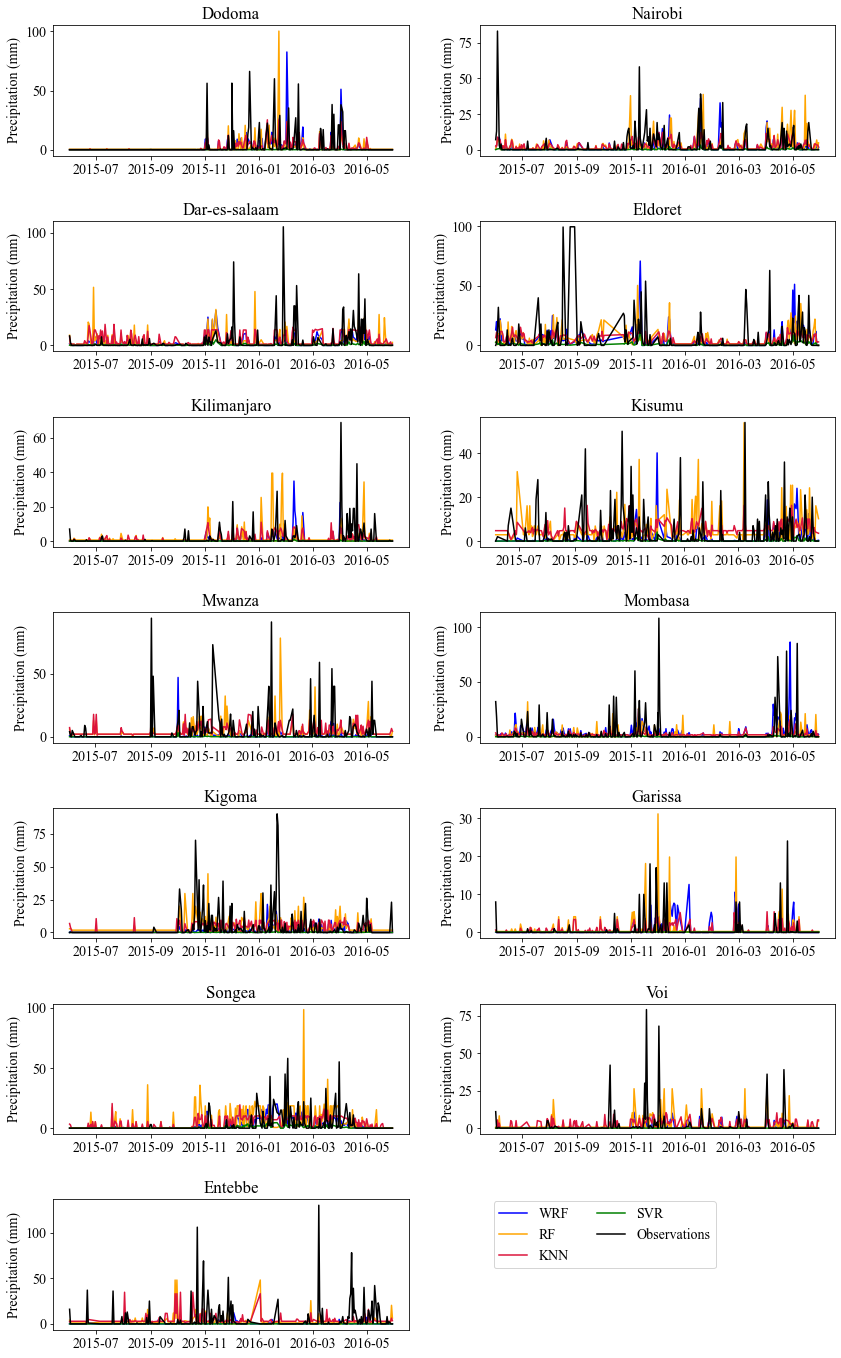

In [11]:
# Plot the timseries

fig, ax = plt.subplots(figsize=(14, 24))#, dpi=500)
plt.gcf().subplots_adjust(hspace=0.5)

plt.subplot(7,2,1)
plt.plot(pd.to_datetime(test_dod['day']), test_dod['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_dod['day']), arr_dod[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_dod['day']), arr_dod[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_dod['day']), arr_dod[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_dod['day']), test_dod['obs_rain'], label='Observations', color='black')
plt.title('Dodoma')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,2)
plt.plot(pd.to_datetime(test_nai['day']), test_nai['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_nai['day']), arr_nai[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_nai['day']), arr_nai[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_nai['day']), arr_nai[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_nai['day']), test_nai['obs_rain'], label='Observations', color='black')
plt.title('Nairobi')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,3)
plt.plot(pd.to_datetime(test_dar['day']), test_dar['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_dar['day']), arr_dar[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_dar['day']), arr_dar[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_dar['day']), arr_dar[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_dar['day']), test_dar['obs_rain'], label='Observations', color='black')
plt.title('Dar-es-salaam')
plt.ylabel('Precipitation (mm)')


plt.subplot(7,2,4)
plt.plot(pd.to_datetime(test_eld['day']), test_eld['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_eld['day']), arr_eld[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_eld['day']), arr_eld[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_eld['day']), arr_eld[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_eld['day']), test_eld['obs_rain'], label='Observations', color='black')
plt.title('Eldoret')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,5)
plt.plot(pd.to_datetime(test_kil['day']), test_kil['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_kil['day']), arr_kil[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_kil['day']), arr_kil[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_kil['day']), arr_kil[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_kil['day']), test_kil['obs_rain'], label='Observations', color='black')
plt.title('Kilimanjaro')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,6)
plt.plot(pd.to_datetime(test_kis['day']), test_kis['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_kis['day']), arr_kis[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_kis['day']), arr_kis[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_kis['day']), arr_kis[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_kis['day']), test_kis['obs_rain'], label='Observations', color='black')
plt.title('Kisumu')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,7)
plt.plot(pd.to_datetime(test_mwa['day']), test_mwa['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_mwa['day']), arr_mwa[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_mwa['day']), arr_mwa[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_mwa['day']), arr_mwa[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_mwa['day']), test_mwa['obs_rain'], label='Observations', color='black')
plt.title('Mwanza')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,8)
plt.plot(pd.to_datetime(test_mom['day']), test_mom['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_mom['day']), arr_mom[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_mom['day']), arr_mom[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_mom['day']), arr_mom[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_mom['day']), test_mom['obs_rain'], label='Observations', color='black')
plt.title('Mombasa')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,9)
plt.plot(pd.to_datetime(test_kig['day']), test_kig['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_kig['day']), arr_kig[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_kig['day']), arr_kig[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_kig['day']), arr_kig[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_kig['day']), test_kig['obs_rain'], label='Observations', color='black')
plt.title('Kigoma')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,10)
plt.plot(pd.to_datetime(test_gar['day']), test_gar['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_gar['day']), arr_gar[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_gar['day']), arr_gar[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_gar['day']), arr_gar[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_gar['day']), test_gar['obs_rain'], label='Observations', color='black')
plt.title('Garissa')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,11)
plt.plot(pd.to_datetime(test_sog['day']), test_sog['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_sog['day']), arr_sog[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_sog['day']), arr_sog[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_sog['day']), arr_sog[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_sog['day']), test_sog['obs_rain'], label='Observations', color='black')
plt.title('Songea')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,12)
plt.plot(pd.to_datetime(test_voi['day']), test_voi['wrf_rain'], label='WRF', color='blue')
plt.plot(pd.to_datetime(test_voi['day']), arr_voi[0], label='WRF_RF', color='orange')
plt.plot(pd.to_datetime(test_voi['day']), arr_voi[1], label='WRF_KNN', color='crimson')
plt.plot(pd.to_datetime(test_voi['day']), arr_voi[2], label='WRF_SVR', color='green')
plt.plot(pd.to_datetime(test_voi['day']), test_voi['obs_rain'], label='Observations', color='black')
plt.title('Voi')
plt.ylabel('Precipitation (mm)')

plt.subplot(7,2,13)
h1 = plt.plot(pd.to_datetime(test_ebb['day']), test_ebb['wrf_rain'], label='WRF', color='blue')
h2 = plt.plot(pd.to_datetime(test_ebb['day']), arr_ebb[0], label='WRF_RF', color='orange')
h3 = plt.plot(pd.to_datetime(test_ebb['day']), arr_ebb[1], label='WRF_KNN', color='crimson')
h4 = plt.plot(pd.to_datetime(test_ebb['day']), arr_ebb[2], label='WRF_SVR', color='green')
h5 = plt.plot(pd.to_datetime(test_ebb['day']), test_ebb['obs_rain'], label='Observations', color='black')
plt.title('Entebbe')
plt.ylabel('Precipitation (mm)')
labels = ['WRF', 'RF', 'KNN', 'SVR', 'Observations']
plt.legend([h1, h2, h3, h4, h5], labels=labels, loc='upper left', 
           bbox_to_anchor=(1.22, 1.04), ncol=2)

#plt.savefig(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\regression\mak_rif\Timeseries.png', 
#           facecolor='white')

### Perform Statistical Evaluation

In [12]:
# The evaluation function primarily only need y_test data so as to compare with the ML predictions, however, x_test has also
# been included so as to perform an evaluation for the WRF model 

def ML_eval(x_test, y_test, arr):
    rmse_rf = np.sqrt(mean_squared_error(y_test, arr[0])).round(2) # arr[0] is the random forest prediction, i.e. rf_pred
    rmse_knn = np.sqrt(mean_squared_error(y_test, arr[1])).round(2) # arr[1] is the knn prediction, i.e. knn_pred
    rmse_svr = np.sqrt(mean_squared_error(y_test, arr[2])).round(2) # arr[2] is the svr prediction, i.e. svr_pred
    rmse_wrf = np.sqrt(mean_squared_error(x_test[:,0], y_test)).round(2)
    mae_rf = mean_absolute_error(y_test, arr[0]).round(2)
    mae_knn = mean_absolute_error(y_test, arr[1]).round(2)
    mae_svr = mean_absolute_error(y_test, arr[2]).round(2)
    mae_wrf = mean_absolute_error(x_test[:,0], y_test).round(2)
    cor_rf = np.corrcoef(y_test, arr[0])[0, 1].round(2)
    cor_knn = np.corrcoef(y_test, arr[1])[0, 1].round(2)
    cor_svr = np.corrcoef(y_test, arr[2])[0, 1].round(2)
    cor_wrf = np.corrcoef(x_test[:,0], y_test)[0, 1].round(2) # x_test data has a 2d shape, so we needed only the info about the rows
    df = pd.DataFrame({'Model':['WRF', 'WRF_RF', 'WRF_KNN', 'WRF_SVR'],
                        'RMSE':[rmse_wrf, rmse_rf, rmse_knn, rmse_svr],
                        'MAE':[mae_wrf, mae_rf, mae_knn, mae_svr],
                        'Corr':[cor_wrf, cor_rf, cor_knn, cor_svr]})
    return df

In [13]:
# Perform the evaluation for each station
ev_dar = ML_eval(x_test_dar, y_test_dar, arr_dar)
ev_dod = ML_eval(x_test_dod, y_test_dod, arr_dod)
ev_eld = ML_eval(x_test_eld, y_test_eld, arr_eld)
ev_ebb = ML_eval(x_test_ebb, y_test_ebb, arr_ebb)
ev_gar = ML_eval(x_test_gar, y_test_gar, arr_gar)
ev_kig = ML_eval(x_test_kig, y_test_kig, arr_kig)
ev_kil = ML_eval(x_test_kil, y_test_kil, arr_kil)
ev_kis = ML_eval(x_test_kis, y_test_kis, arr_kis)
ev_mom = ML_eval(x_test_mom, y_test_mom, arr_mom)
ev_mwa = ML_eval(x_test_mwa, y_test_mwa, arr_mwa)
ev_nai = ML_eval(x_test_nai, y_test_nai, arr_nai)
ev_sog = ML_eval(x_test_sog, y_test_sog, arr_sog)
ev_voi = ML_eval(x_test_voi, y_test_voi, arr_voi)

In [14]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [15]:
display_side_by_side(ev_dod, ev_dar, ev_nai, ev_eld,
                     titles=['Dar-es-salaam','Dodoma', 'Nairobi', 'Eldoret'])

,Model,RMSE,MAE,Corr
0,WRF,9.36,2.47,0.24
1,WRF_RF,10.38,3.38,0.14
2,WRF_KNN,8.46,3.02,0.37
3,WRF_SVR,9.37,2.47,0.24
,Model,RMSE,MAE,Corr
0,WRF,11.10,3.21,0.19
1,WRF_RF,11.65,5.01,0.17
2,WRF_KNN,10.87,5.35,0.23
3,WRF_SVR,10.93,3.20,0.19
,Model,RMSE,MAE,Corr


In [16]:
display_side_by_side(ev_kil, ev_mwa, ev_kis, ev_mom,
                     titles=['Kilimanjaro','Mwanza', 'Kisumu', 'Mombasa'])

,Model,RMSE,MAE,Corr
0,WRF,6.05,1.57,0.18
1,WRF_RF,7.14,2.79,0.15
2,WRF_KNN,5.58,1.97,0.32
3,WRF_SVR,6.05,1.57,0.18
,Model,RMSE,MAE,Corr
0,WRF,12.56,4.02,0.07
1,WRF_RF,13.16,6.07,0.07
2,WRF_KNN,11.87,5.98,0.17
3,WRF_SVR,12.53,4.01,0.07
,Model,RMSE,MAE,Corr


In [17]:
display_side_by_side(ev_kig, ev_sog, ev_gar, ev_voi,
                     titles=['Kigoma','Songea', 'Garissa', 'Voi'])

,Model,RMSE,MAE,Corr
0,WRF,10.67,3.42,0.24
1,WRF_RF,10.72,5.22,0.16
2,WRF_KNN,9.85,4.29,0.26
3,WRF_SVR,10.65,3.41,0.24
,Model,RMSE,MAE,Corr
0,WRF,7.45,2.21,0.34
1,WRF_RF,10.17,5.20,0.29
2,WRF_KNN,7.55,4.19,0.27
3,WRF_SVR,7.14,2.24,0.34
,Model,RMSE,MAE,Corr


In [18]:
display_side_by_side(ev_ebb, titles=['Entebbe'])

,Model,RMSE,MAE,Corr
0,WRF,15.02,5.08,0.05
1,WRF_RF,15.18,6.75,0.03
2,WRF_KNN,15.22,7.36,-0.04
3,WRF_SVR,15.03,5.08,0.05
